In [75]:
# import necessary imports
import numpy as np
#from numpy_ml.neural_nets.optimizers import Adam
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

In [76]:
def get_batch(input, batch_size,chunk_size):

    input_batch = []
    # print(type(input_batch))
    target_batch = []
    idx = np.random.randint(0,len(input)-(chunk_size+1),size=batch_size)
    for i in range(0,len(idx)-1):
        input_batch.append(input[idx[i]:idx[i]+chunk_size])
        target_batch.append(input[idx[i]+1:idx[i]+(chunk_size+1)])
    
    input_batch = np.array(input_batch)
    target_batch = np.array(target_batch)

    return input_batch, target_batch

In [77]:
with open (r"indices_text.txt", 'r') as f:
  indices_text = eval(f.read())
  
x,y = get_batch(indices_text,4,8)
print(x.shape)
print(x)
print(y.shape)
print(y)

(3, 8)
[[  77 1272  740  192 1292  810  918 1297]
 [ 786  790 1083  529 1539   71   10 1262]
 [ 437  840  665 1304  598 1336  789  360]]
(3, 8)
[[1272  740  192 1292  810  918 1297 1266]
 [ 790 1083  529 1539   71   10 1262  438]
 [ 840  665 1304  598 1336  789  360  805]]


In [ ]:
class neural_embedding:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.token_embedding_table = np.random.rand(vocab_size, vocab_size)

    def calculate_softmax(self, x):
        """Takes input array x and returns softmax."""
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # Numerical stability
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


    def calculate_cross_entropy(self, y_hatless, y_hat):
        """
        Takes target (y_hatless) and prediction (y_hat) and computes cross entropy loss.
        """
        # get vocab_size
        _, _, vocab_size = y_hat.shape        
        y_hat = y_hat.reshape(y_hat.shape[0]*y_hat.shape[1], y_hat.shape[2])
        y_hatless_flat = y_hatless.reshape(-1)
        # one-hot encode targets
        y_hatless_hot = np.eye(vocab_size)[y_hatless_flat]
       
        y_hat = self.calculate_softmax(y_hat)
        
        # Clip predictions to avoid log(0)
        y_hat = np.clip(y_hat, 1e-15, 1.0) 
        return -np.sum(y_hatless_hot*np.log(y_hat))
    
    def forward(self, idx, targets=None):
        """
        Implements forward pass with an unnecessary logitte function 
        which i only did not delete because now I'm emotionally attached.
        Args:
            idx(np.array): (B,T) numpy array of integers
            targets(np.array): (B,T) numpy array of integers
        Returns:
            input_logits(np.array)
            sometimes also: targets(np.array)
        """
        batch_size, chunk_size = idx.shape
        logits = np.zeros((batch_size, chunk_size, (self.token_embedding_table[0].size)))

        def logitte(batch_size, chunk_size, input):
            for batch in range(batch_size):
                for chunk in range(chunk_size):
                    # (B,T,C) b=batch_size, t="time"=chunk_size, c=vocab_size
                    logits[batch][chunk] = self.token_embedding_table[input[batch][chunk]]
                    
            return logits

        input_logits = logitte(batch_size, chunk_size, idx)
        
        if targets is not None:
            loss = self.calculate_cross_entropy(targets, input_logits)

            return input_logits, loss

        return input_logits

    
    def backward(self, targets, input_logits):
        batch_size = 32
        chunk_size = 8
        # need to do the same reshaping as we did for cross entropy, apparently
        targets_flat = targets.reshape(-1)
        inputs_flat = input_logits.reshape(-1)
        one_hot_targets = np.eye(self.vocab_size)[targets_flat]
        one_hot_inputs = np.eye(self.vocab_size)[inputs_flat]

        # shape after: ((batch_size*chunk_size), vocab_size)
        input_logits_2d = input_logits.reshape(input_logits.shape[0]*input_logits.shape[1], input_logits.shape[2])
        
        soft_input = self.calculate_softmax(input_logits_2d)
        # somehow this is supposedly the combination of the derivative of softmax with the derivative of the CCE
        # delta = one_hot_targets - soft_input
        delta = soft_input - one_hot_targets

        # want shape (80,80) for matrix multiplication, but with correct indices (use one-hot targets for that)
        delta_indexed = np.dot(one_hot_inputs.transpose(),delta)

        # compute gradient for weight matrix: dot product between the transpose of the to layer and delta vector computed above
        gradient = (self.token_embedding_table.T @ delta_indexed) 
        
        # Calculate gradients for the embedding table
        # gradient = np.zeros_like(self.token_embedding_table)
        # for batch in range(batch_size):
        #     for chunk in range(chunk_size):
        #         gradient[idx[batch][chunk]] += delta[batch][chunk]
    
        return gradient

    

In [79]:
# currently do not use loss at all, so something is probably very wrong

def train(model, text, optimiser, param_tensor, train_step):
    batch_size=32
    chunk_size = 8
    losses = []

    for steps in range(train_step): 
        # sample batch of data
        xb, yb = get_batch(text, batch_size, chunk_size) 
        optimiser.zero_grad()  # reset gradients
        # get logits and loss
        logits, loss = model.forward(xb, yb)
        losses.append(float(loss.copy()))

        gradient = model.backward(yb, logits)
        param_tensor.grad = torch.tensor(gradient, dtype=torch.float32)
        optimiser.step()  # apply gradients to parameters
        # diff = model.token_embedding_table - np.array(token_embedding_table)
        # print(f"Difference in weights before - afte Adam: {diff}")
        #/model.token_embedding_table = np.array(token_embedding_table)
        model.token_embedding_table = param_tensor.detach().numpy()
    return losses
        

In [80]:
with open (r"indices_text.txt", 'r') as f:
    indices_text = eval(f.read())
with open(r"vocab_train.txt", 'r') as f:
    vocab_train = eval(f.read())

In [81]:
vocab_size = len(vocab_train)

my_neural_embedding = neural_embedding(vocab_size)
param_dict = {"weight": my_neural_embedding.token_embedding_table} # one entry, key is weight and value is my_neural

tensor = torch.tensor(my_neural_embedding.token_embedding_table, dtype=torch.float32, requires_grad=True)
optimiser = optim.Adam([tensor], lr=0.001)
loss = train(my_neural_embedding, indices_text, optimiser, tensor, 100000)


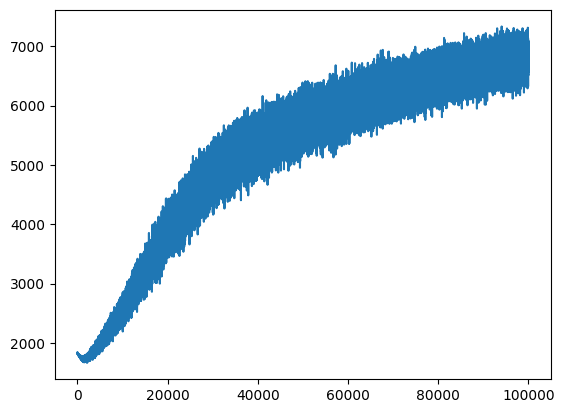

In [82]:
y = np.arange(1, len(loss)+1)
plt.plot(y, loss)
plt.show()

In [83]:
print(loss)

[1833.7344799562081, 1828.5370340687232, 1825.3713507253165, 1825.065162388435, 1834.14908859891, 1837.528843830306, 1827.2991262922142, 1824.4821644579504, 1829.298367286377, 1835.9061166290505, 1830.1549207987844, 1825.9541785989045, 1826.6023757582361, 1834.1205427945974, 1833.5808196392336, 1829.6568405921018, 1830.2071736506389, 1828.01622576961, 1827.0551234477766, 1832.969734892844, 1820.1408116070243, 1820.6340378900952, 1819.8403961760037, 1832.1651184498512, 1823.0040061108366, 1832.4618153738068, 1824.2167214978106, 1827.4602489186561, 1829.126192930901, 1823.0602079625203, 1822.98148994508, 1826.2070087738184, 1827.2077877324166, 1831.440156797494, 1830.168772853041, 1824.8950893852832, 1824.7754211869756, 1820.0823723324588, 1829.3733540490807, 1829.418100648165, 1822.7880804168753, 1819.7292588429625, 1831.562365544362, 1823.524769610878, 1825.640733369626, 1825.2986520947584, 1822.6054447571623, 1815.7562169619505, 1824.3548435399803, 1827.5124581372795, 1821.44187954840

In [84]:
import pickle

matrix = [[1, 2, 3], [4, 5, 6]]

with open('matrix.pkl', 'wb') as f:
    pickle.dump(my_neural_embedding.token_embedding_table, f)




In [85]:
# Laden:

with open('matrix.pkl', 'rb') as f:
    loaded = pickle.load(f)
print(loaded)

[[ 43.141575  32.163292 -34.154472 ...  35.618423  62.11367   40.435387]
 [ 42.882805  33.180862  33.295326 ...  35.8354    58.075813  40.20674 ]
 [-44.2337    31.818596 -34.244576 ...  35.503754  39.500854  39.907295]
 ...
 [ 43.318314  33.2049    33.482315 ...  35.817104  62.3766   -41.07381 ]
 [ 40.433178  30.169939  30.697424 ...  33.82866   73.39031  -42.334003]
 [ 42.762096  32.55046   33.335423 ... -36.106052 -87.575554  40.749794]]
